# Graphing + Statistical Analysis

In [1]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import math
import re
import numpy as np
from itertools import combinations

### SURVEY 1 - Initial Datasets

In [2]:
S1_data = pd.read_csv("/work/data/3) final_data/Survey 1.csv")
S2_Und_data = pd.read_csv("/work/data/3) final_data/Survey 2 - 1.csv")
S2_AI_Human_data = pd.read_csv("/work/data/3) final_data/Survey 2 - 2.csv")
S3_data = pd.read_csv("/work/data/3) final_data/Survey 3.csv")

Question_Names_Eval = ["Und_Q", "Und_R", "Valid", "Trust", "Satis", "Follow", "Action", "Info"]
Question_Names_S2 = ["Und_Q", "Und_R", "AI_or_Human", "Confidence"]
Response_Source = ["Doctor", "High Accuracy AI", "Low Accuracy AI"]
Random_Headers = ['Doctor', 'AI', 'Doctor + AI']

### Install libraries

In [3]:
#@markdown Install libraries

!pip install 'pingouin==0.5.2'
!pip install 'scikit-posthocs == 0.7.0'
!pip install 'statannotations == 0.4.4'

from IPython.display import clear_output 
clear_output()

In [4]:


import itertools
import scikit_posthocs as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def prerun_stats (sample_keys, group_label, data, y, stats_viz=False):

  ## Stats
  import scipy.stats as stats
  from pingouin import welch_anova, pairwise_gameshowell, pairwise_tukey
  from statistics import stdev
  import numpy as np
  
  MIN_SAMPLE_SIZE = 25
  TOLERANCE = 0.15

  sample_data = [data.copy().apply(lambda z: z[y] if z[group_label] == key else None, axis=1).dropna() for key in sample_keys]
  #sample_data = [data[data[group_label]==key][y] for key in sample_keys]


  sample_data_w_keys = pd.concat([pd.DataFrame({y:data.values, group_label:sample_keys[i]}) for i, data in enumerate(sample_data.copy())], axis=0, ignore_index=True)
  
  if stats_viz is True:
    print(f"Running stats between the samples: {sample_keys}")

  # Means for each sample group
  means_table = data[group_label].value_counts()

  # Check if *all* data points for each sample group are over 25
  sample_sizes_sufficient = all([sample > MIN_SAMPLE_SIZE for sample in means_table])

  # Check if means are equal within the TOLERANCE for each sample group
  sample_sizes_equal = all([abs(sample1 - sample2) < np.mean(means_table) * TOLERANCE for sample1, sample2 in itertools.combinations(means_table, 2)])

  # Dunn Test
  dunn = sp.posthoc_dunn(sample_data, p_adjust='bonferroni')
  replacer = {i+1:key for i, key in enumerate(sample_keys)}
  dunn.rename(columns = replacer, index=replacer, inplace=True)

  # Compile all stats into list
  statz = {'sample_sizes_sufficient': sample_sizes_sufficient,
          'sample_sizes_equal':      sample_sizes_equal,
          'shapiro':                 stats.shapiro(data[y]),
          'levene':                  stats.levene(*sample_data),
          'f_oneway':                stats.f_oneway(*sample_data),
          'kruskal':                 stats.kruskal(*sample_data),
          'welch_anova':             welch_anova(dv=y, between=group_label, data=sample_data_w_keys),
          'gameshowell':             pairwise_gameshowell(dv=y, between=group_label, data=sample_data_w_keys).round(3),
          'tukey':                   pairwise_tukey(dv=y, between=group_label, data=sample_data_w_keys).round(3),
          'dunn':                    dunn,
          'mean_std':                {key:{'mean' : np.mean(population), \
                                           'std' : stats.tstd(population)} for key, population in zip(sample_keys, sample_data)},
  }

  return statz



def stats_tree(sample_keys, sample_sizes_sufficient, sample_sizes_equal, shapiro, levene, f_oneway, kruskal, welch_anova, gameshowell, tukey, dunn, mean_std=None, stats_viz=False):

  import itertools

  ALPHA = 0.05
  indent = '   '


  if sample_sizes_sufficient or shapiro.pvalue > ALPHA:
    if stats_viz is True:
      print("> Sample size sufficient" if sample_sizes_sufficient else f">Sample size insufficient but *normality is met*: w_shapiro={shapiro.statistic}, p_shapiro={shapiro.pvalue}")

    if sample_sizes_equal or levene.pvalue > ALPHA:
      if stats_viz is True:
        print(f"{indent*1}> Sample sizes equal" if sample_sizes_equal else f"{indent*1}>Sample sizes not equal but *homogeneity is met*: s_levene={levene.statistic}, p_levene={levene.pvalue}")

      if f_oneway.pvalue < ALPHA:
        if stats_viz is True:
          print(f"{indent*2}> Thus running BASIC ANOVA:\n{indent*3}> Basic ANOVA (f_oneway) *significant*: s_bANOVA={f_oneway.statistic}, p_bANOVA={f_oneway.pvalue}")
          print(f"\n> Thus running Tukey Test:")
          print(tukey)
          print(f"mean_std: {mean_std}")

        pairs = (zip(tukey["A"].tolist(), tukey["B"].tolist()))
        p_values = tukey["p-tukey"].tolist()
        
        return pairs, p_values

      elif f_oneway.pvalue > ALPHA:
        if stats_viz is True:
          print(f"{indent*2}> Thus running BASIC ANOVA:\n{indent*3}> Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA={f_oneway.statistic}, p_bANOVA={f_oneway.pvalue}" if stats_viz is True else "")
          print(f"mean_std: {mean_std}" )

        pairs = (zip(tukey["A"].tolist(), tukey["B"].tolist()))
        p_values = tukey["p-tukey"].tolist()

        return pairs, p_values

    elif not sample_sizes_equal or levene.pvalue < ALPHA:
      if stats_viz is True:
        print(f"{indent*1}> Sample sizes are unequal and homogeneity *NOT MET*: w_levene={levene.statistic}, p_levene={levene.pvalue}")

      if welch_anova['p-unc'][0] < ALPHA:
        if stats_viz is True:
          print(f"{indent*3}> Thus running ANOVA Welch:\n{indent*4}> ANOVA Welch *SIGNIFICANT*: welch=\n{welch_anova}")#{welch_anova['F']}, p_welch={welch_anova['p-unc'][0]}")
          print(f"\n>Thus running Games-Howell test:")
          print(gameshowell)
          print(f"mean_std: {mean_std}")
        
        pairs = (zip(gameshowell["A"].tolist(), gameshowell["B"].tolist()))
        p_values = gameshowell["pval"].tolist()

        return pairs, p_values

      elif welch_anova['p-unc'][0] > ALPHA:
        if stats_viz is True:
          print(f"{indent*3}> Thus running ANOVA Welch:\n{indent*4}> ANOVA Welch *NOT SIGNIFICANT*: welch=\n{welch_anova}")#F_welch={welch_anova['F']}, p_welch={welch_anova['p-unc'][0]}")
          print(f"mean_std: {mean_std}")

        pairs = (zip(gameshowell["A"].tolist(), gameshowell["B"].tolist()))
        p_values = gameshowell["pval"].tolist()

        return pairs, p_values

  elif not sample_sizes_sufficient or shapiro.pvalue < ALPHA:
    if stats_viz is True:
      print(f"{indent*1}> Both minimum sample size and normality were *NOT MET*: w_shapiro={shapiro.statistic}, p_shapiro={shapiro.pvalue}")

    if kruskal.pvalue < ALPHA:
      if stats_viz is True:
        print(f"{indent*2}> Thus running Kruskal Wallis:\n Kruskal Wallis *SIGNIFICANT*: s_kruskal={kruskal.statistic}, p_kruskal={kruskal.pvalue}")
        print(f"{indent*2}> Running DUNN test:")
        print(dunn)
        print(f"mean_std: {mean_std}")
      
      pairs = [p for p in itertools.combinations(sample_keys, 2)]
      p_values = [dunn.at[x[0],x[1]] for x in pairs]

      return pairs, p_values

    elif kruskal.pvalue > ALPHA:
      if stats_viz is True:
        print(f"{indent*2}> Thus running Kruskal Wallis:\n{indent*3}>Kruskal Wallis *NOT SIGNIFICANT*: s_kruskal={kruskal.statistic}, p_kruskal={kruskal.pvalue}")
        print(f"mean_std: {mean_std}")
      
      pairs = [p for p in itertools.combinations(sample_keys, 2)]
      p_values = [dunn.at[x[0],x[1]] for x in pairs]

      return pairs, p_values



def plot_stats(pairs, p_values, y, x, hue=None, figsize=[4,8], ylim=None, **kwgs):

  from statannotations.Annotator import Annotator

  if figsize is None and hue is not None:
    figsize = [data[x].nunique()*data[hue].nunique()*1.2, 8]
  elif figsize is None and hue is None:
    figsize = [data[x].nunique()*1.2, 8]

  # plot 
  fig, ax = plt.subplots(figsize=figsize)
  plt.tight_layout()
  sns.barplot(ax=ax, **plot_params)
  annot = Annotator(ax, pairs, **plot_params)
  annot.configure(text_format="star", loc='outside', line_offset=True, line_offset_to_group=True, line_height=.01)
  annot.set_pvalues_and_annotate(p_values)

  # styling
  #ax.text(x=0.5, y=-0.3, s=lbl, fontsize=10, ha='center', va='bottom', transform=ax.transAxes)

  #ax.set_title(f"{y} for {x}")
  #if hue is not None:
    #ax.set_title(f"{y} for {x} by {hue.lower()}")


  if ylim is not None:
    ax.set_ylim(ylim)

  ax.get_legend().remove()
  ax.set_xlabel('')
  ax.set_ylabel('')

  plt.show()


def stats(data, y, x, hue=None, graph_viz=True, stats_viz=False, ylim=None, figsize=None, **kwgs):

  target_data = [data] # The data to be used for statistical analysis
  target_label = x # The column name with the groups to be compared between
  within_sample = [None] # The value of a column for hue groups to be compared within 

  if hue is not None:

    within_sample = data[x].unique()
    target_data = [data[data[x]==group] for group in within_sample]
    target_label = hue

  pairs = []
  p_values = []

  for i, data in enumerate(target_data):
    
    if stats_viz is True:
      print(f"----\nWithin the '{within_sample[i]}' group of '{x}':\n----" if len(within_sample) > 1 else "----")

    sample_keys = [key for key in data[target_label].unique()]
    stat_results = prerun_stats (sample_keys, target_label, data, y, stats_viz=stats_viz)
    pair, p_value = stats_tree(sample_keys, **stat_results, stats_viz=stats_viz)

    for pair_item, p_value_item in zip(pair, p_value):
      if hue is not None:
        pair_item = [pair_w_sample_label for pair_w_sample_label in itertools.product([within_sample[i]],pair_item)]
      pairs.append(pair_item)
      p_values.append(p_value_item)
    print("----" if stats_viz is True else "")

  if graph_viz:
    plot_stats(pairs, p_values, ylim=ylim, figsize=figsize, **plot_params)

print("Installation Complete")

Installation Complete


In [5]:
palette = ["lightgrey", "darkseagreen", "lightcoral"]

### SURVEY 1 - Graphs

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
/root/venv/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=1.8983800320947783, p_bANOVA=0.1503748371583371
mean_std: {'Doctor': {'mean': 3.9775700934579437, 'std': 1.3466840116013867}, 'High Accuracy AI': {'mean': 4.070440251572327, 'std': 1.2073671571874176}, 'Low Accuracy AI': {'mean': 3.8700934579439257, 'std': 1.3428199074106393}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Und_Q_Doctor vs. Und_Q_High Accuracy AI: Custom statistic

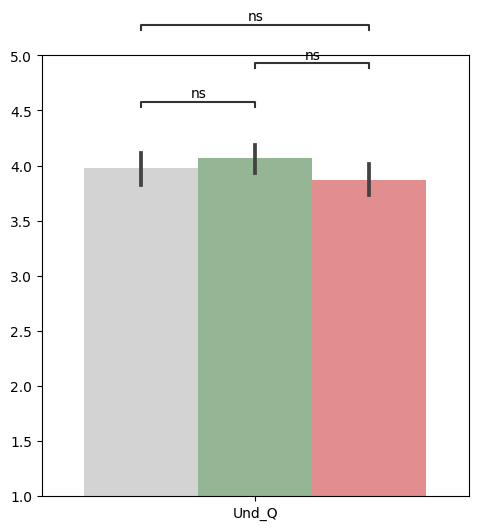

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=37.22199939637017, p_bANOVA=2.70780314655089e-16

> Thus running Tukey Test:
                  A                 B  mean(A)  mean(B)   diff     se      T  \
0            Doctor  High Accuracy AI    3.973    4.584 -0.611  0.076 -8.046   
1            Doctor   Low Accuracy AI    3.973    4.482 -0.509  0.076 -6.714   
2  High Accuracy AI   Low Accuracy AI    4.584    4.482  0.102  0.076  1.348   

   p-tukey  hedges  
0    0.000  -0.636  
1    0.000  -0.529  
2    0.369   0.106  
mean_std: {'Doctor': {'mean': 3.9732087227414334, 'std': 1.2127314147921113}, 'High Accuracy AI': {'mean': 4.584276729559749, 'std': 0.7266477710115709}, 'Low Accuracy AI': {'mean': 4.481931464174455, 'std': 0.8728817261165238}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
  

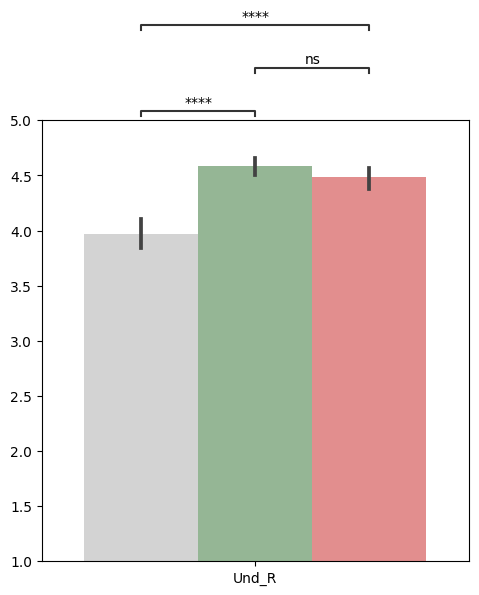

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=13.770657926127097, p_bANOVA=1.2731582702304514e-06

> Thus running Tukey Test:
                  A                 B  mean(A)  mean(B)   diff     se      T  \
0            Doctor  High Accuracy AI    0.814    0.949 -0.135  0.026 -5.211   
1            Doctor   Low Accuracy AI    0.814    0.868 -0.053  0.026 -2.059   
2  High Accuracy AI   Low Accuracy AI    0.949    0.868  0.082  0.026  3.155   

   p-tukey  hedges  
0    0.000  -0.414  
1    0.099  -0.163  
2    0.005   0.251  
mean_std: {'Doctor': {'mean': 0.8144654088050315, 'std': 0.38934329211523866}, 'High Accuracy AI': {'mean': 0.9490445859872612, 'std': 0.22025771556184937}, 'Low Accuracy AI': {'mean': 0.8675078864353313, 'std': 0.3395610123504955}}
----
p-value annotation legend:
      ns: p <= 1.00

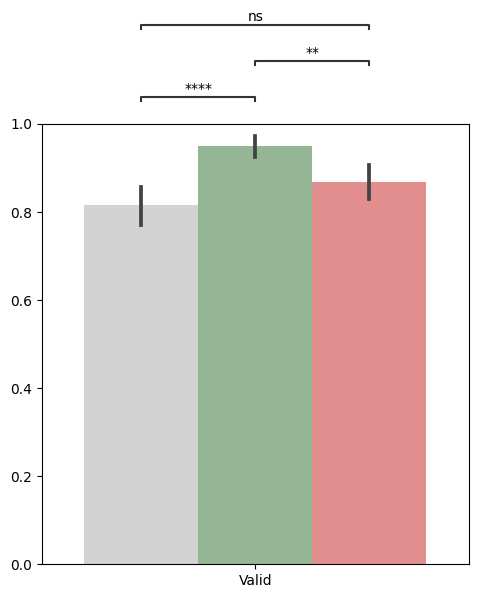

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=12.62240225564106, p_bANOVA=3.88343890977108e-06

> Thus running Tukey Test:
                  A                 B  mean(A)  mean(B)   diff     se      T  \
0            Doctor  High Accuracy AI    3.854    4.262 -0.408  0.081 -5.024   
1            Doctor   Low Accuracy AI    3.854    4.058 -0.204  0.081 -2.524   
2  High Accuracy AI   Low Accuracy AI    4.262    4.058  0.203  0.081  2.506   

   p-tukey  hedges  
0    0.000  -0.397  
1    0.032  -0.199  
2    0.033   0.198  
mean_std: {'Doctor': {'mean': 3.853894080996885, 'std': 1.136246056647109}, 'High Accuracy AI': {'mean': 4.261635220125785, 'std': 0.8641692454678145}, 'Low Accuracy AI': {'mean': 4.058255451713395, 'std': 1.0561436678030591}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
    

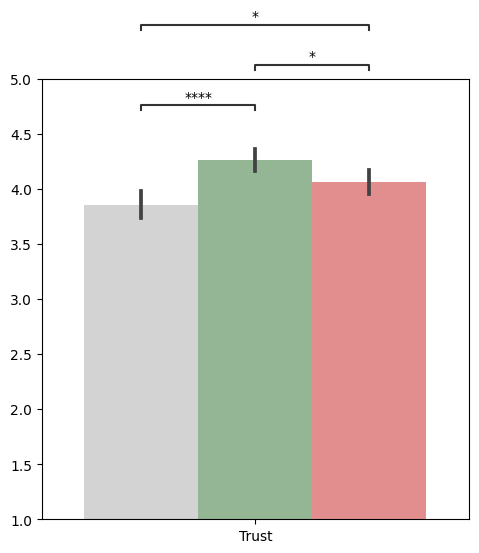

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=11.94732787136731, p_bANOVA=7.499960389569887e-06

> Thus running Tukey Test:
                  A                 B  mean(A)  mean(B)   diff     se      T  \
0            Doctor  High Accuracy AI    3.546     4.03 -0.483  0.099 -4.884   
1            Doctor   Low Accuracy AI    3.546     3.77 -0.223  0.099 -2.262   
2  High Accuracy AI   Low Accuracy AI    4.030     3.77  0.260  0.099  2.628   

   p-tukey  hedges  
0    0.000  -0.386  
1    0.062  -0.178  
2    0.024   0.208  
mean_std: {'Doctor': {'mean': 3.5464174454828665, 'std': 1.3278252662510621}, 'High Accuracy AI': {'mean': 4.029874213836478, 'std': 1.1126264079016395}, 'Low Accuracy AI': {'mean': 3.7697819314641747, 'std': 1.300621107316619}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
 

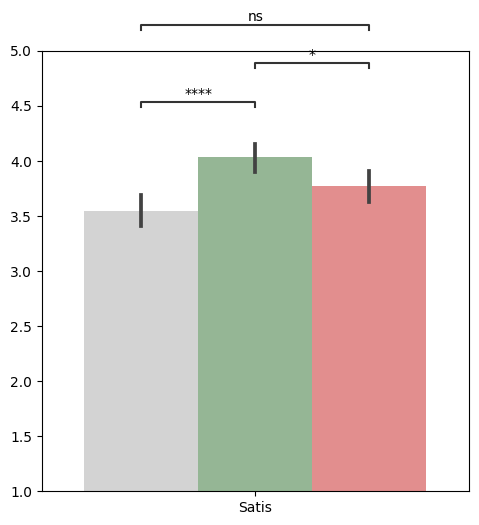

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=6.724621214582678, p_bANOVA=0.0012585350083481382

> Thus running Tukey Test:
                  A                 B  mean(A)  mean(B)   diff     se      T  \
0            Doctor  High Accuracy AI    3.678    4.003 -0.326  0.089 -3.665   
1            Doctor   Low Accuracy AI    3.678    3.849 -0.171  0.089 -1.930   
2  High Accuracy AI   Low Accuracy AI    4.003    3.849  0.155  0.089  1.740   

   p-tukey  hedges  
0    0.001  -0.290  
1    0.131  -0.152  
2    0.191   0.138  
mean_std: {'Doctor': {'mean': 3.6778816199376942, 'std': 1.2020983730304138}, 'High Accuracy AI': {'mean': 4.003459119496855, 'std': 1.0178318562503144}, 'Low Accuracy AI': {'mean': 3.8489096573208723, 'std': 1.1392460752347118}}
----
p-value annotation legend:
      ns: p <= 1.00e+00


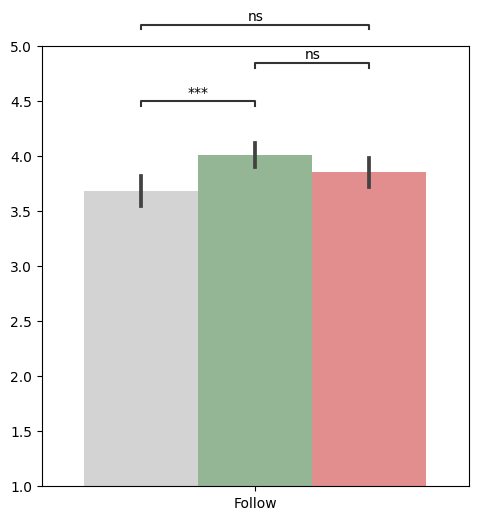

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=2.9278988532128216, p_bANOVA=0.05398886531815169
mean_std: {'Doctor': {'mean': 3.419314641744548, 'std': 1.3096758296678606}, 'High Accuracy AI': {'mean': 3.564779874213836, 'std': 1.2436406494467969}, 'Low Accuracy AI': {'mean': 3.6616822429906546, 'std': 1.2773736380616882}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Action_Doctor vs. Action_High Accuracy AI: Custom statistical test, P_val:3.210e-01
Action_High Accuracy AI vs. Action_Low Accuracy AI: Custom statistical test, P_val:6.030e-01
Action_Doctor vs. Action_Low Accuracy AI: Custom statistical test, P_val:4.300e-02


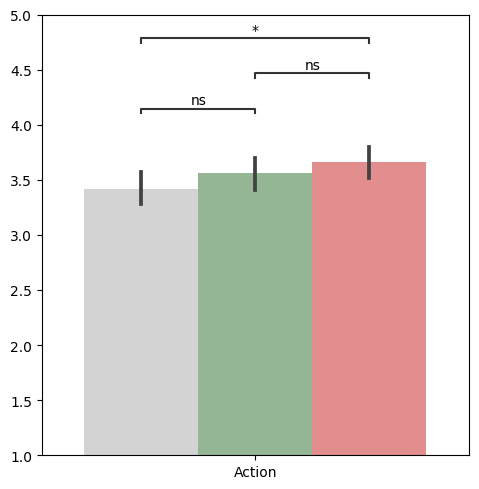

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=4.907018408941985, p_bANOVA=0.007581620083970313

> Thus running Tukey Test:
                  A                 B  mean(A)  mean(B)   diff     se      T  \
0            Doctor  High Accuracy AI    3.941    3.648  0.293  0.099  2.966   
1            Doctor   Low Accuracy AI    3.941    3.881  0.060  0.099  0.607   
2  High Accuracy AI   Low Accuracy AI    3.648    3.881 -0.233  0.099 -2.361   

   p-tukey  hedges  
0    0.009   0.234  
1    0.816   0.048  
2    0.048  -0.187  
mean_std: {'Doctor': {'mean': 3.940809968847352, 'std': 1.1738230666928946}, 'High Accuracy AI': {'mean': 3.647798742138365, 'std': 1.3564583909237913}, 'Low Accuracy AI': {'mean': 3.8809968847352025, 'std': 1.2084779696441574}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
  

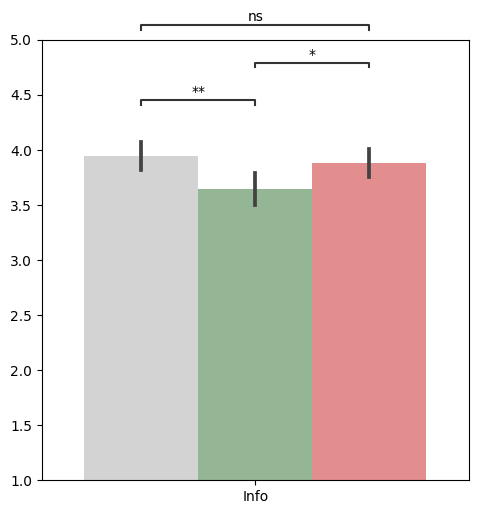

In [6]:
for ques in Question_Names_Eval:
    temp_ds = pd.DataFrame()
    temp_ds.insert(0, "Question Type", 0)
    temp_ds.insert(1, "Response Scores", 0)
    temp_ds.insert(2, "Response Source", 0)

    ques_list = list(S1_data["Question Type"])

    for i in range(len(ques_list)):
        if ques_list[i] == ques:
            temp_ds.loc[len(temp_ds)] = S1_data.loc[i, :].values.flatten().tolist()[1:4]

    if ques != "Valid":
        plot_params = {
            'x': "Question Type",
            'y' : "Response Scores",
            'hue' : 'Response Source',
            'data' : temp_ds,
            'palette': palette,
            'order' : [ques],
            'hue_order' : ['Doctor', 'High Accuracy AI', 'Low Accuracy AI'],
        }
        stats(**plot_params, graph_viz=True, ylim=[1,5], figsize=[5,5], stats_viz=True)

    else:
        plot_params = {
            'x': "Question Type",
            'y' : "Response Scores",
            'hue' : 'Response Source',
            'data' : temp_ds,
            'palette': palette,
            'order' : [ques],
            'hue_order' : ['Doctor', 'High Accuracy AI', 'Low Accuracy AI'],
        }
        stats(**plot_params, graph_viz=True, ylim=[0,1], figsize=[5,5], stats_viz=True)


### SURVEY 2 - Graphs

Understanding Question  - Survey 1

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=1.540055104581219, p_bANOVA=0.21488923060078016
mean_std: {'Doctor': {'mean': 4.201519756838906, 'std': 1.1164092594192392}, 'High Accuracy AI': {'mean': 4.276051779935275, 'std': 1.034914487921651}, 'Low Accuracy AI': {'mean': 4.121637426900585, 'std': 1.2012455449896922}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Und_Q_Doctor vs. Und_Q_High Accuracy AI: Custom statistical test, P_val:6.790e-01
Und_Q_High Accuracy AI vs. Und_Q_Low Accuracy AI: Custom statistical test, P_val:1.860e-01
Und_Q_Doctor vs. Und_Q_Low Accuracy AI: Custom statistical test, P_val:6.270e-01


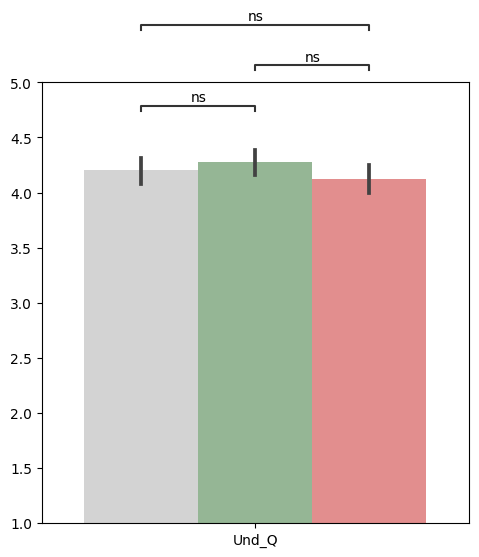

----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=10.852430926198842, p_bANOVA=2.179915784394599e-05

> Thus running Tukey Test:
                  A                 B  mean(A)  mean(B)   diff     se      T  \
0            Doctor  High Accuracy AI    4.322    4.527 -0.205  0.057 -3.601   
1            Doctor   Low Accuracy AI    4.322    4.563 -0.241  0.055 -4.354   
2  High Accuracy AI   Low Accuracy AI    4.527    4.563 -0.037  0.056 -0.650   

   p-tukey  hedges  
0    0.001  -0.285  
1    0.000  -0.336  
2    0.793  -0.051  
mean_std: {'Doctor': {'mean': 4.322188449848024, 'std': 0.829612060963108}, 'High Accuracy AI': {'mean': 4.5268608414239475, 'std': 0.6914765281725588}, 'Low Accuracy AI': {'mean': 4.563450292397661, 'std': 0.6172332758987862}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
 

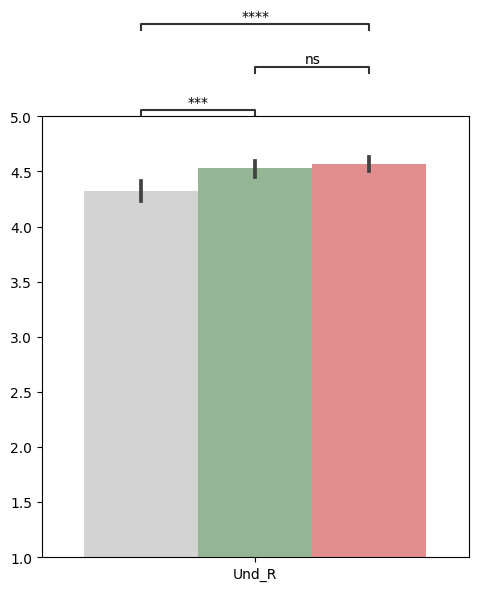

In [7]:
for ques in Question_Names_S2[0:-2]:
    temp_ds = pd.DataFrame()
    temp_ds.insert(0, "Question Type", 0)
    temp_ds.insert(1, "Response Scores", 0)
    temp_ds.insert(2, "Response Source", 0)

    ques_list = list(S2_Und_data["Question Type"])

    for i in range(len(ques_list)):
        if ques_list[i] == ques:
            temp_ds.loc[len(temp_ds)] = S2_Und_data.loc[i, :].values.flatten().tolist()[1:4]

    #display(temp_ds)
    plot_params = {
        'x': "Question Type",
        'y' : "Response Scores",
        'hue' : 'Response Source',
        'data' : temp_ds,
        'palette': palette,
        'order' : [ques],
        'hue_order' : ['Doctor', 'High Accuracy AI', 'Low Accuracy AI'],
    }
    stats(**plot_params, graph_viz=True, ylim=[1,5], figsize=[5,5], stats_viz=True)


----
Running stats between the samples: ['Doctor', 'High Accuracy AI', 'Low Accuracy AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.42541281917860446, p_bANOVA=0.6536209451382233
mean_std: {'Doctor': {'mean': 0.5015197568389058, 'std': 0.5007593018801078}, 'High Accuracy AI': {'mean': 0.5307443365695793, 'std': 0.49986338653997353}, 'Low Accuracy AI': {'mean': 0.49707602339181284, 'std': 0.5007240388861424}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

AI_or_Human_Doctor vs. AI_or_Human_High Accuracy AI: Custom statistical test, P_val:7.410e-01
AI_or_Human_High Accuracy AI vs. AI_or_Human_Low Accuracy AI: Custom statistical test, P_val:6.670e-01
AI_or_Human_Doctor vs. AI_or_Human_Low Accuracy AI: Custom statistical test, P_val:9.930e-01


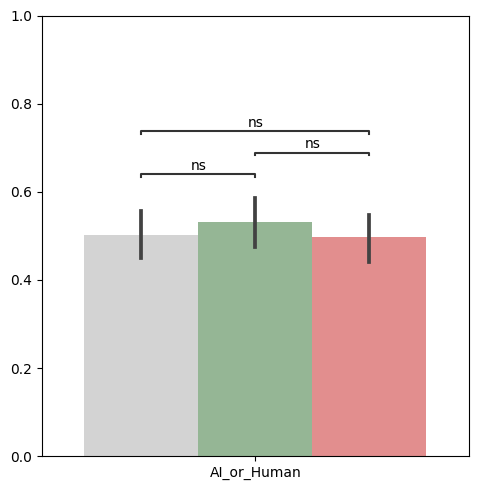

In [8]:
plot_params = {
    'x': "Question Type",
    'y' : "Response Scores",
    'hue' : 'Response Source',
    'data' : S2_AI_Human_data,
    'palette': palette,
    'order' : ["AI_or_Human"],
    'hue_order' : ['Doctor', 'High Accuracy AI', 'Low Accuracy AI'],
}
stats(**plot_params, graph_viz=True, ylim=[0,1], figsize=[5,5], stats_viz=True)


In [9]:
#palette_2_H = ['darkseagreen', '#689268']
#palette_2_L = ['lightcoral', 'indianred']
#palette_2_D = ['lightgray', 'darkgray']

palette_2 = ['#acc8d7', '#779eb2']
palette_2_L = ['lightcoral', 'lightcoral']
palette_2_D = ['lightgray', 'lightgray']

#palettes_2 = [palette_2_D, palette_2_H, palette_2_L]

----
Running stats between the samples: ['Correct', 'Incorrect']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.1937354781591389, p_bANOVA=0.6601164179426241
mean_std: {'Correct': {'mean': 3.937575757575757, 'std': 0.8750854672650424}, 'Incorrect': {'mean': 3.979268292682927, 'std': 0.8426132014940404}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Doctor_Correct vs. Doctor_Incorrect: Custom statistical test, P_val:6.600e-01


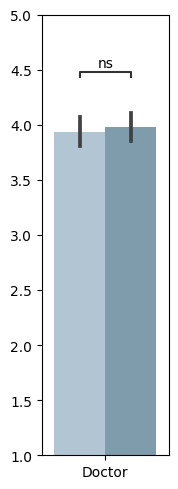

----
Running stats between the samples: ['Correct', 'Incorrect']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.0172584632821923, p_bANOVA=0.8955675054030509
mean_std: {'Correct': {'mean': 3.784146341463414, 'std': 0.9143665227697222}, 'Incorrect': {'mean': 3.7703448275862073, 'std': 0.9297643173534651}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

High Accuracy AI_Correct vs. High Accuracy AI_Incorrect: Custom statistical test, P_val:8.960e-01


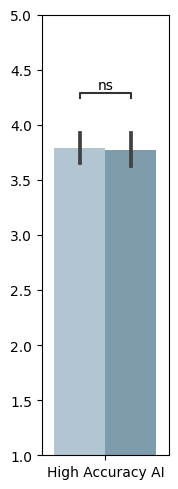

----
Running stats between the samples: ['Incorrect', 'Correct']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.9296759878423628, p_bANOVA=0.3356324058506459
mean_std: {'Incorrect': {'mean': 4.0249999999999995, 'std': 0.8406433765573292}, 'Correct': {'mean': 3.94, 'std': 0.7884821760901348}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Low Accuracy AI_Correct vs. Low Accuracy AI_Incorrect: Custom statistical test, P_val:3.360e-01


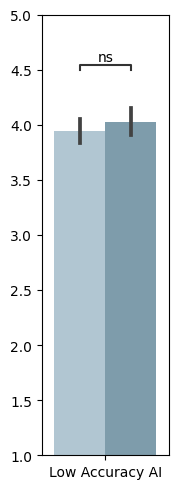

In [10]:
for j in range(len(Response_Source)):
    source = Response_Source[j]
    temp_ds = pd.DataFrame()
    temp_ds.insert(0, "Response Source", 0)
    temp_ds.insert(1, "Incorrect/Correct", 0)
    temp_ds.insert(2, "Confidence", 0)

    source_2_list = list(S2_AI_Human_data["Response Source"])

    for i in range(len(source_2_list)):
        if source_2_list[i] == source:
            temp_list = S2_AI_Human_data.loc[i, :].values.flatten().tolist()
            temp_ds.loc[len(temp_ds)] = [temp_list[5], temp_list[2], temp_list[4]]
    
    plot_params = {
        'x': "Response Source",
        'y' : "Confidence",
        'hue' : 'Incorrect/Correct',
        'data' : temp_ds,
        'palette': palette_2,
        'order' : [source],
        'hue_order' : ['Correct', 'Incorrect'],

    }
    stats(**plot_params, graph_viz=True, ylim=[1,5], figsize=[2,5], stats_viz=True)


### SURVEY 3 - Graphs

In [14]:
#palette_3 = 
palette_3_H = ['#dbe8d7', '#b8d1ae', 'darkseagreen']
palette_3_L = ['#ffd6d6', '#ffb3b3', 'lightcoral']
palette_3_D = ['lightgray', 'darkgray', 'dimgray']

palettes_3 = [palette_3_D, palette_3_H, palette_3_L]

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=0.2693377680890659, p_levene=0.7640539762528897
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.3362263870758904, p_bANOVA=0.7147072945713299
mean_std: {'Doctor': {'mean': 4.071681415929204, 'std': 1.2338578456662919}, 'Doctor + AI': {'mean': 4.01864406779661, 'std': 1.2197764368892152}, 'AI': {'mean': 3.935, 'std': 1.203645556741114}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Und_Q - D_Doctor vs. Und_Q - D_AI: Custom statistical test, P_val:6.930e-01
Und_Q - D_AI vs. Und_Q - D_Doctor + AI: Custom statistical test, P_val:8.690e-01
Und_Q - D_Doctor vs. Und_Q - D_Doctor + AI: Custom statistical test, P_val:9.420e-01


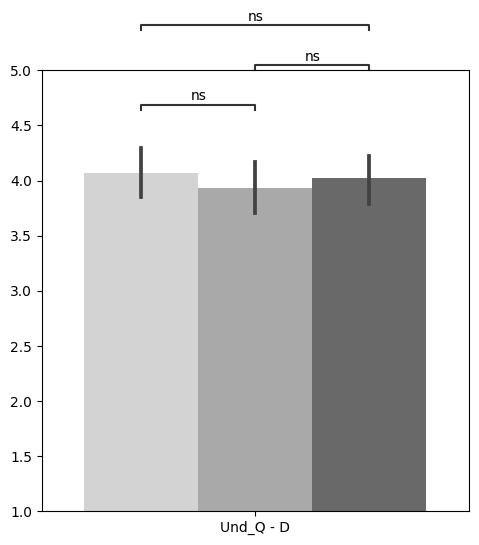

----
Running stats between the samples: ['AI', 'Doctor + AI', 'Doctor']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=1.6831185195607319, p_levene=0.18739430338776064
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=2.962732908475335, p_bANOVA=0.0530622584944026
mean_std: {'AI': {'mean': 3.7737864077669903, 'std': 1.2878741539001504}, 'Doctor + AI': {'mean': 4.0328, 'std': 1.1929751369661292}, 'Doctor': {'mean': 4.1825242718446605, 'std': 1.1859824408039512}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Und_Q - H_Doctor vs. Und_Q - H_AI: Custom statistical test, P_val:4.400e-02
Und_Q - H_AI vs. Und_Q - H_Doctor + AI: Custom statistical test, P_val:2.500e-01
Und_Q - H_Doctor vs. Und_Q - H_Doctor + AI: Custom statistical test, P_val:6.270e-01


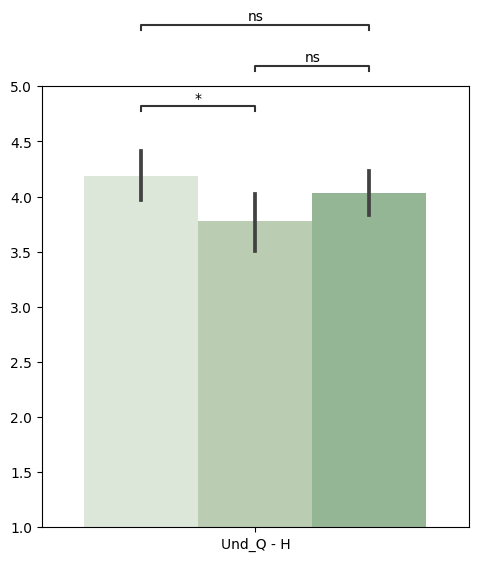

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.4951908262292634, p_bANOVA=0.6098999914159169
mean_std: {'Doctor': {'mean': 3.9894736842105263, 'std': 1.2658459986197788}, 'Doctor + AI': {'mean': 4.058878504672897, 'std': 1.1777779903418097}, 'AI': {'mean': 3.9, 'std': 1.1514608412644858}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Und_Q - L_Doctor vs. Und_Q - L_AI: Custom statistical test, P_val:8.380e-01
Und_Q - L_AI vs. Und_Q - L_Doctor + AI: Custom statistical test, P_val:5.840e-01
Und_Q - L_Doctor vs. Und_Q - L_Doctor + AI: Custom statistical test, P_val:9.030e-01


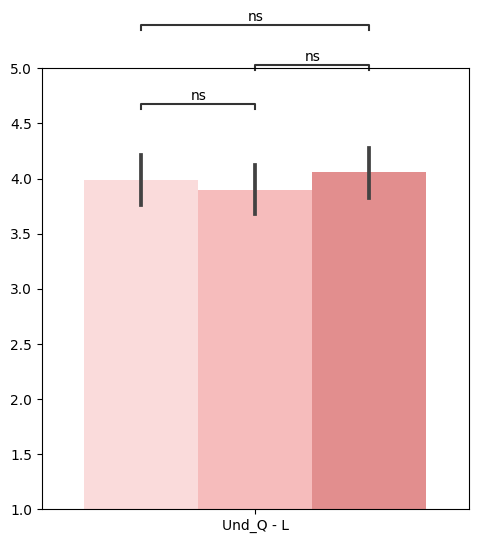

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=1.0367832904985048, p_levene=0.3557525609103775
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=1.5142721441897715, p_bANOVA=0.22150193215891428
mean_std: {'Doctor': {'mean': 4.158407079646017, 'std': 1.0340390348839432}, 'Doctor + AI': {'mean': 3.903389830508474, 'std': 1.1866012804940236}, 'AI': {'mean': 4.014, 'std': 1.117267590457572}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Und_R - D_Doctor vs. Und_R - D_AI: Custom statistical test, P_val:6.130e-01
Und_R - D_AI vs. Und_R - D_Doctor + AI: Custom statistical test, P_val:7.460e-01
Und_R - D_Doctor vs. Und_R - D_Doctor + AI: Custom statistical test, P_val:1.930e-01


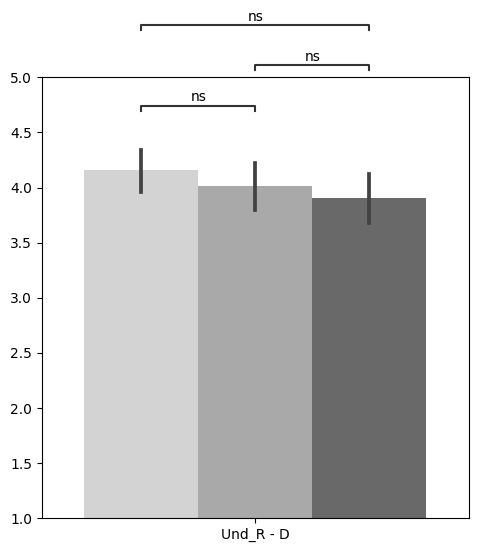

----
Running stats between the samples: ['AI', 'Doctor + AI', 'Doctor']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=2.6796997020375124, p_levene=0.07008526954475805
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=3.099148295323671, p_bANOVA=0.04641050849199274

> Thus running Tukey Test:
        A            B  mean(A)  mean(B)   diff     se      T  p-tukey  hedges
0      AI       Doctor    4.368    4.649 -0.281  0.113 -2.489    0.035  -0.346
1      AI  Doctor + AI    4.368    4.514 -0.146  0.108 -1.353    0.367  -0.179
2  Doctor  Doctor + AI    4.649    4.514  0.135  0.108  1.253    0.423   0.166
mean_std: {'AI': {'mean': 4.367961165048544, 'std': 0.8810881855035417}, 'Doctor + AI': {'mean': 4.513599999999999, 'std': 0.8141237125614501}, 'Doctor': {'mean': 4.648543689320388, 'std': 0.7228570869615717}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      *

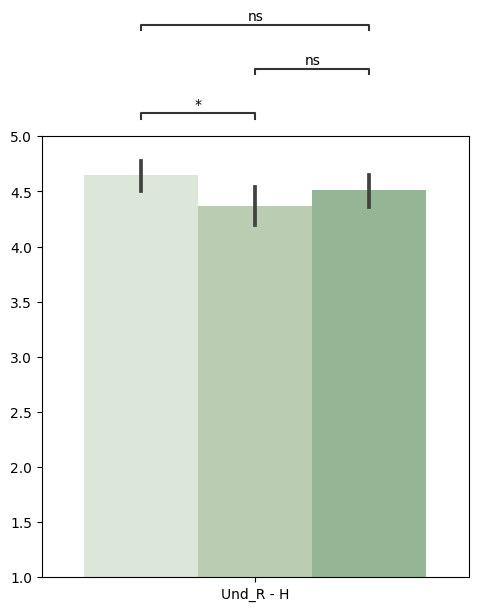

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=1.186941008676977, p_bANOVA=0.30643325533948296
mean_std: {'Doctor': {'mean': 4.442105263157895, 'std': 0.9001371318183962}, 'Doctor + AI': {'mean': 4.392523364485982, 'std': 0.8288092088277195}, 'AI': {'mean': 4.271794871794872, 'std': 0.8603173185483158}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Und_R - L_Doctor vs. Und_R - L_AI: Custom statistical test, P_val:2.930e-01
Und_R - L_AI vs. Und_R - L_Doctor + AI: Custom statistical test, P_val:5.490e-01
Und_R - L_Doctor vs. Und_R - L_Doctor + AI: Custom statistical test, P_val:9.050e-01


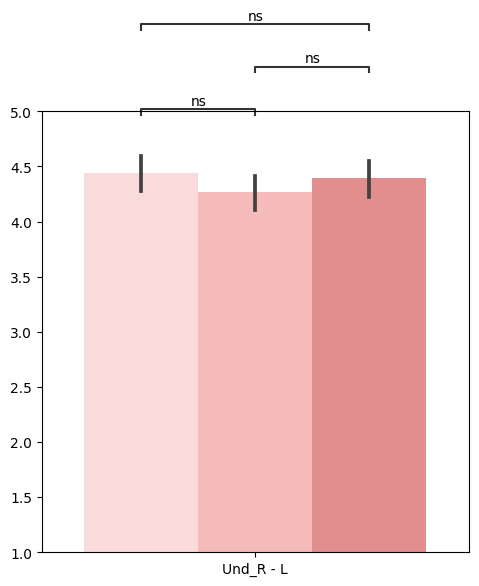

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=0.6398689379340653, p_levene=0.5280205325041311
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.6398689379340646, p_bANOVA=0.5280205325041311
mean_std: {'Doctor': {'mean': 0.8584070796460177, 'std': 0.35018506936557703}, 'Doctor + AI': {'mean': 0.8290598290598291, 'std': 0.37807585196346727}, 'AI': {'mean': 0.8, 'std': 0.40201512610368484}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Valid - D_Doctor vs. Valid - D_AI: Custom statistical test, P_val:4.960e-01
Valid - D_AI vs. Valid - D_Doctor + AI: Custom statistical test, P_val:8.380e-01
Valid - D_Doctor vs. Valid - D_Doctor + AI: Custom statistical test, P_val:8.250e-01


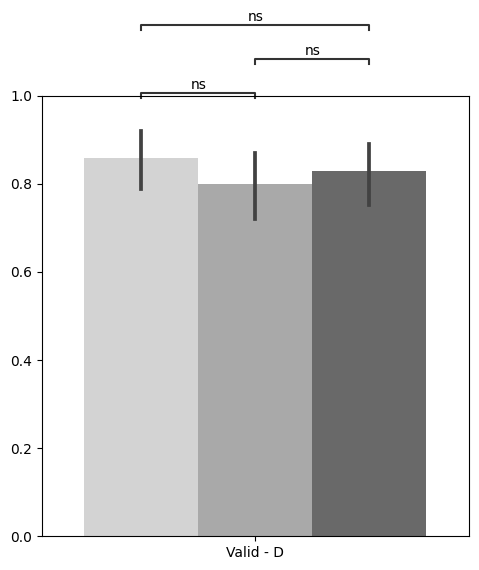

----
Running stats between the samples: ['AI', 'Doctor + AI', 'Doctor']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=0.059725585985349064, p_levene=0.9420333077426374
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.05972558598534898, p_bANOVA=0.9420333077426374
mean_std: {'AI': {'mean': 0.9514563106796117, 'std': 0.21596299504635688}, 'Doctor + AI': {'mean': 0.952, 'std': 0.21462645719722495}, 'Doctor': {'mean': 0.9603960396039604, 'std': 0.1959995958775385}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Valid - H_Doctor vs. Valid - H_AI: Custom statistical test, P_val:9.500e-01
Valid - H_AI vs. Valid - H_Doctor + AI: Custom statistical test, P_val:1.000e+00
Valid - H_Doctor vs. Valid - H_Doctor + AI: Custom statistical test, P_val:9.520e-01


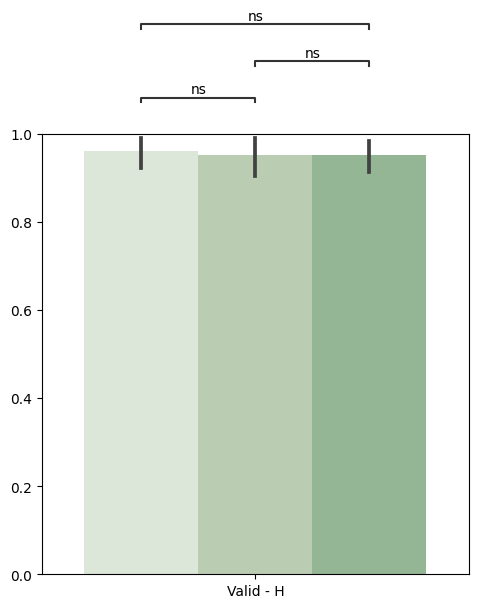

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.3848257089181579, p_bANOVA=0.6808715054194117
mean_std: {'Doctor': {'mean': 0.8584070796460177, 'std': 0.35018506936557703}, 'Doctor + AI': {'mean': 0.897196261682243, 'std': 0.3051315657855203}, 'AI': {'mean': 0.8793103448275862, 'std': 0.3271795787661864}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Valid - L_Doctor vs. Valid - L_AI: Custom statistical test, P_val:8.800e-01
Valid - L_AI vs. Valid - L_Doctor + AI: Custom statistical test, P_val:9.130e-01
Valid - L_Doctor vs. Valid - L_Doctor + AI: Custom statistical test, P_val:6.560e-01


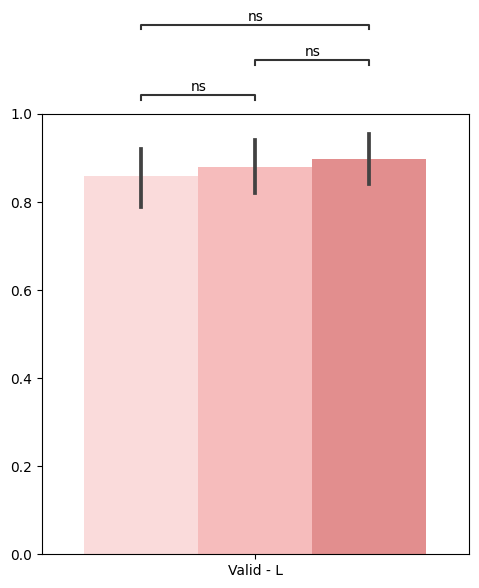

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=1.0803605756404355, p_levene=0.34067795748567825
      > Thus running BASIC ANOVA:
         > Basic ANOVA (f_oneway) *significant*: s_bANOVA=4.674910016182857, p_bANOVA=0.009956602946450165

> Thus running Tukey Test:
        A            B  mean(A)  mean(B)   diff     se      T  p-tukey  hedges
0      AI       Doctor    3.871    4.154 -0.283  0.142 -1.999    0.114  -0.274
1      AI  Doctor + AI    3.871    3.747  0.124  0.140  0.882    0.652   0.119
2  Doctor  Doctor + AI    4.154    3.747  0.407  0.136  2.996    0.008   0.393
mean_std: {'Doctor': {'mean': 4.153982300884956, 'std': 0.9235060714308588}, 'Doctor + AI': {'mean': 3.747457627118644, 'std': 1.1175914168927166}, 'AI': {'mean': 3.8710000000000004, 'std': 1.039064750415274}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      

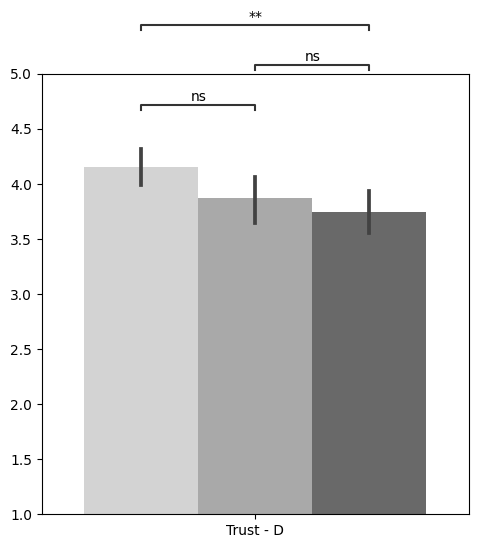

----
Running stats between the samples: ['AI', 'Doctor + AI', 'Doctor']
> Sample size sufficient
   > Sample sizes are unequal and homogeneity *NOT MET*: w_levene=3.138457520071284, p_levene=0.04465428543120737
         > Thus running ANOVA Welch:
            > ANOVA Welch *SIGNIFICANT*: welch=
          Source  ddof1      ddof2          F     p-unc       np2
0  Random Header      2  218.20719  11.229506  0.000023  0.057552

>Thus running Games-Howell test:
        A            B  mean(A)  mean(B)   diff     se      T       df  pval  \
0      AI       Doctor    4.103    4.547 -0.444  0.107 -4.151  203.873   0.0   
1      AI  Doctor + AI    4.103    4.101  0.002  0.114  0.019  225.999   1.0   
2  Doctor  Doctor + AI    4.547    4.101  0.446  0.113  3.962  225.882   0.0   

   hedges  
0  -0.576  
1   0.002  
2   0.526  
mean_std: {'AI': {'mean': 4.102912621359223, 'std': 0.7765504807498771}, 'Doctor + AI': {'mean': 4.1008000000000004, 'std': 0.9413867601884279}, 'Doctor': {'mean': 4.546

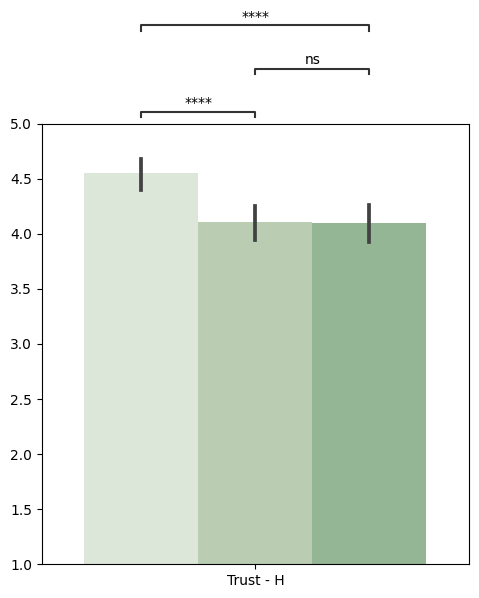

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.9188440619249059, p_bANOVA=0.3999830856143488
mean_std: {'Doctor': {'mean': 4.094736842105263, 'std': 0.9301100996074116}, 'Doctor + AI': {'mean': 4.007476635514018, 'std': 0.9490512575953367}, 'AI': {'mean': 3.92991452991453, 'std': 0.8949344955093523}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Trust - L_Doctor vs. Trust - L_AI: Custom statistical test, P_val:3.660e-01
Trust - L_AI vs. Trust - L_Doctor + AI: Custom statistical test, P_val:8.050e-01
Trust - L_Doctor vs. Trust - L_Doctor + AI: Custom statistical test, P_val:7.630e-01


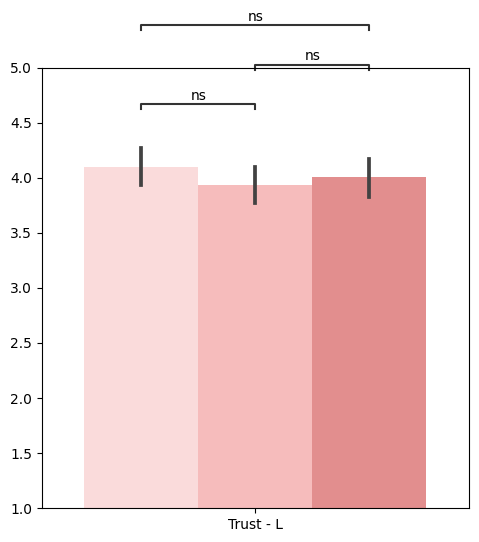

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=0.09252611498059815, p_levene=0.9116491891451008
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.308114310152107, p_bANOVA=0.7350437645580428
mean_std: {'Doctor': {'mean': 3.727433628318584, 'std': 1.2478730323756773}, 'Doctor + AI': {'mean': 3.6084745762711856, 'std': 1.2208709425334312}, 'AI': {'mean': 3.627, 'std': 1.2078744165105104}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Satis - D_Doctor vs. Satis - D_AI: Custom statistical test, P_val:8.220e-01
Satis - D_AI vs. Satis - D_Doctor + AI: Custom statistical test, P_val:9.930e-01
Satis - D_Doctor vs. Satis - D_Doctor + AI: Custom statistical test, P_val:7.420e-01


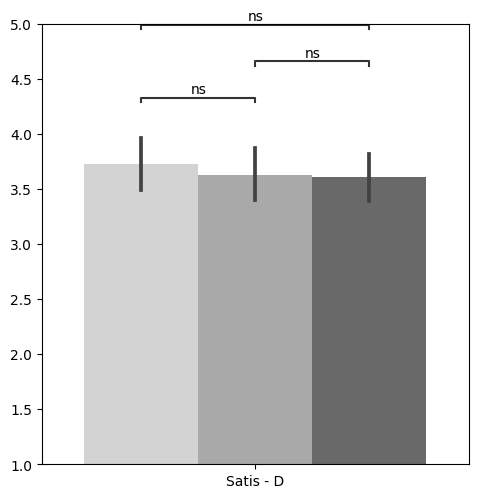

----
Running stats between the samples: ['AI', 'Doctor + AI', 'Doctor']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=1.1174443927941258, p_levene=0.3283567396936378
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=2.879018978738835, p_bANOVA=0.057611083465384925
mean_std: {'AI': {'mean': 3.9572815533980585, 'std': 0.9315390955924348}, 'Doctor + AI': {'mean': 3.9112000000000005, 'std': 1.121794069998532}, 'Doctor': {'mean': 4.229126213592234, 'std': 1.0802714862079597}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Satis - H_Doctor vs. Satis - H_AI: Custom statistical test, P_val:1.540e-01
Satis - H_AI vs. Satis - H_Doctor + AI: Custom statistical test, P_val:9.420e-01
Satis - H_Doctor vs. Satis - H_Doctor + AI: Custom statistical test, P_val:6.200e-02


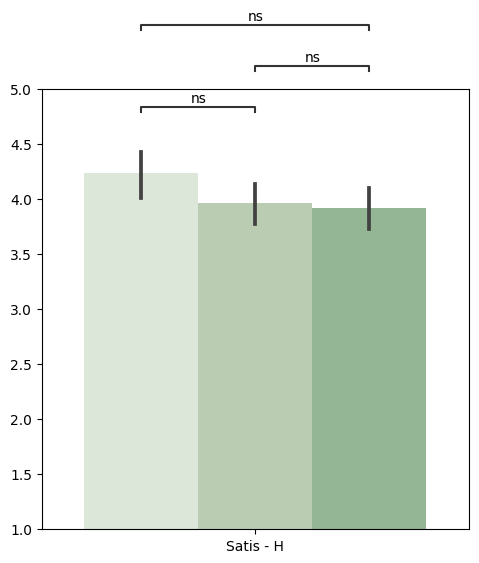

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.09290420429496934, p_bANOVA=0.9113042634466902
mean_std: {'Doctor': {'mean': 3.607894736842105, 'std': 1.28270626086157}, 'Doctor + AI': {'mean': 3.6766355140186917, 'std': 1.1866060241136083}, 'AI': {'mean': 3.64957264957265, 'std': 1.1171564836228978}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Satis - L_Doctor vs. Satis - L_AI: Custom statistical test, P_val:9.620e-01
Satis - L_AI vs. Satis - L_Doctor + AI: Custom statistical test, P_val:9.840e-01
Satis - L_Doctor vs. Satis - L_Doctor + AI: Custom statistical test, P_val:9.050e-01


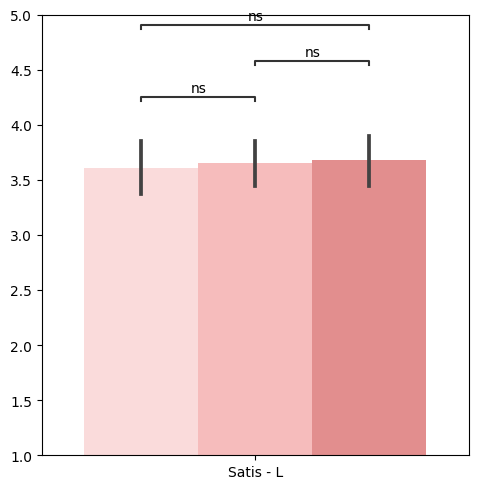

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=2.1428121166246252, p_levene=0.11896404679228158
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.6100911790490783, p_bANOVA=0.5439166856870992
mean_std: {'Doctor': {'mean': 3.8530973451327437, 'std': 0.9483134273597237}, 'Doctor + AI': {'mean': 3.7042372881355936, 'std': 1.1667321643003998}, 'AI': {'mean': 3.7329999999999997, 'std': 1.1021608711338768}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Follow - D_Doctor vs. Follow - D_AI: Custom statistical test, P_val:6.960e-01
Follow - D_AI vs. Follow - D_Doctor + AI: Custom statistical test, P_val:9.790e-01
Follow - D_Doctor vs. Follow - D_Doctor + AI: Custom statistical test, P_val:5.460e-01


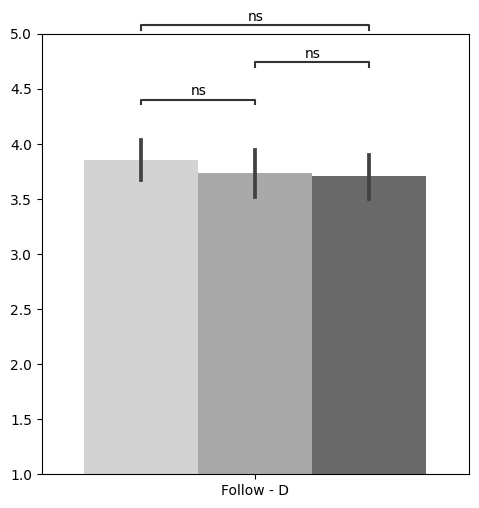

----
Running stats between the samples: ['AI', 'Doctor + AI', 'Doctor']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=0.3180680644141595, p_levene=0.7277774152924357
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=1.3203707451807158, p_bANOVA=0.26845179303588335
mean_std: {'AI': {'mean': 3.9281553398058255, 'std': 0.9453101447411947}, 'Doctor + AI': {'mean': 3.9976, 'std': 1.0180994311033196}, 'Doctor': {'mean': 4.141747572815534, 'std': 0.9162502731823856}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Follow - H_Doctor vs. Follow - H_AI: Custom statistical test, P_val:2.520e-01
Follow - H_AI vs. Follow - H_Doctor + AI: Custom statistical test, P_val:8.510e-01
Follow - H_Doctor vs. Follow - H_Doctor + AI: Custom statistical test, P_val:5.010e-01


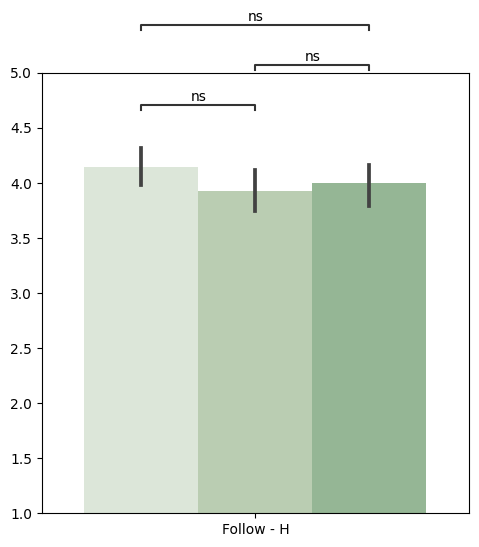

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.6129716773534309, p_bANOVA=0.5423450744790942
mean_std: {'Doctor': {'mean': 3.6938596491228073, 'std': 0.9725693630626133}, 'Doctor + AI': {'mean': 3.8271028037383172, 'std': 1.0772580578923288}, 'AI': {'mean': 3.694017094017094, 'std': 1.0357648014115979}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Follow - L_Doctor vs. Follow - L_AI: Custom statistical test, P_val:1.000e+00
Follow - L_AI vs. Follow - L_Doctor + AI: Custom statistical test, P_val:5.980e-01
Follow - L_Doctor vs. Follow - L_Doctor + AI: Custom statistical test, P_val:6.010e-01


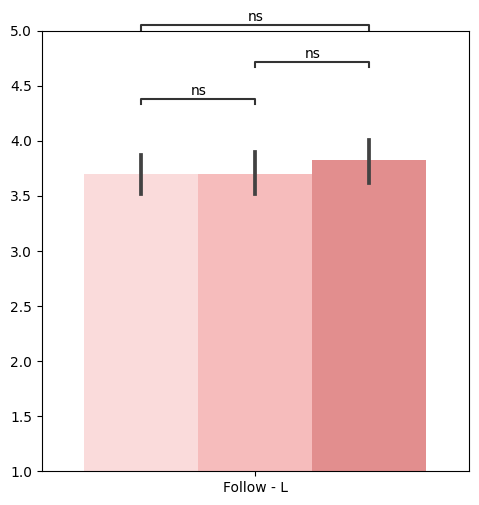

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=1.9036573023134122, p_levene=0.15066543636326243
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.3200764772695326, p_bANOVA=0.7263200371934315
mean_std: {'Doctor': {'mean': 3.482300884955752, 'std': 1.0517188387600467}, 'Doctor + AI': {'mean': 3.5940677966101693, 'std': 1.2348426227890914}, 'AI': {'mean': 3.583, 'std': 1.1684449650555375}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Action - D_Doctor vs. Action - D_AI: Custom statistical test, P_val:8.010e-01
Action - D_AI vs. Action - D_Doctor + AI: Custom statistical test, P_val:9.970e-01
Action - D_Doctor vs. Action - D_Doctor + AI: Custom statistical test, P_val:7.430e-01


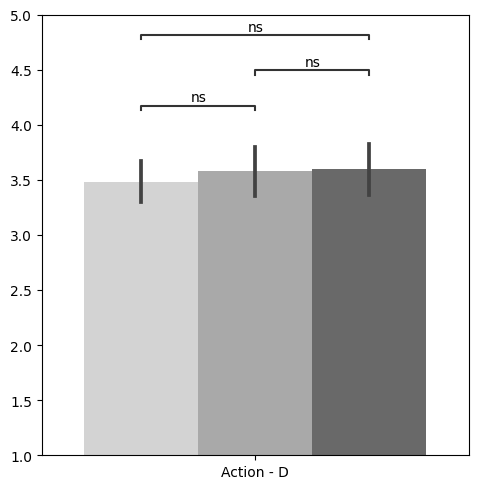

----
Running stats between the samples: ['AI', 'Doctor + AI', 'Doctor']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=1.2545361620643516, p_levene=0.2865729540718954
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.2325754234907423, p_bANOVA=0.7926205536303174
mean_std: {'AI': {'mean': 3.6359223300970878, 'std': 1.100610736776742}, 'Doctor + AI': {'mean': 3.6728, 'std': 1.260912112257912}, 'Doctor': {'mean': 3.74368932038835, 'std': 1.0706118740630648}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Action - H_Doctor vs. Action - H_AI: Custom statistical test, P_val:7.810e-01
Action - H_AI vs. Action - H_Doctor + AI: Custom statistical test, P_val:9.690e-01
Action - H_Doctor vs. Action - H_Doctor + AI: Custom statistical test, P_val:8.890e-01


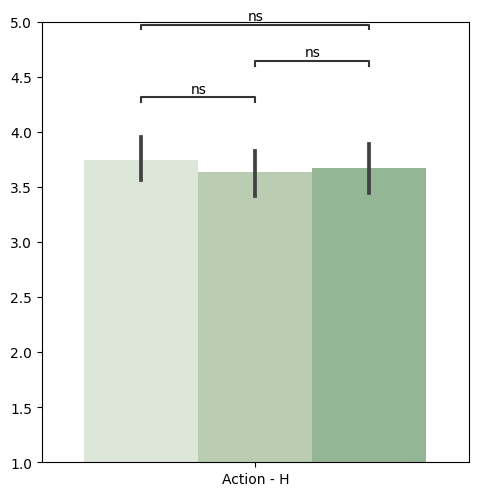

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=2.54027892697062, p_bANOVA=0.08036240931256673
mean_std: {'Doctor': {'mean': 3.486842105263158, 'std': 1.1104900582800783}, 'Doctor + AI': {'mean': 3.8271028037383177, 'std': 1.132085243595044}, 'AI': {'mean': 3.6188034188034193, 'std': 1.1431151949623135}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Action - L_Doctor vs. Action - L_AI: Custom statistical test, P_val:6.480e-01
Action - L_AI vs. Action - L_Doctor + AI: Custom statistical test, P_val:3.530e-01
Action - L_Doctor vs. Action - L_Doctor + AI: Custom statistical test, P_val:6.600e-02


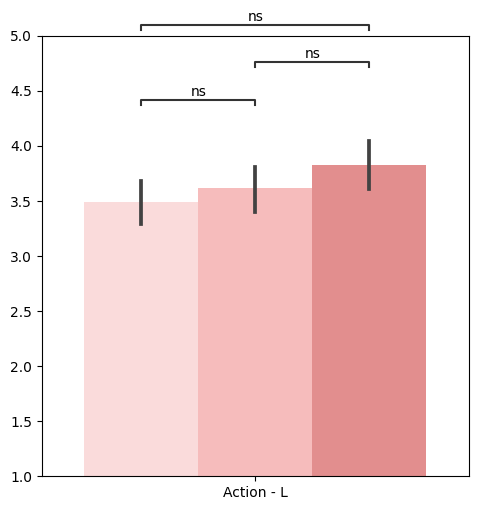

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   >Sample sizes not equal but *homogeneity is met*: s_levene=1.24404187346285, p_levene=0.28957319404796916
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=0.7149308327808032, p_bANOVA=0.4899866978171239
mean_std: {'Doctor': {'mean': 3.7752212389380535, 'std': 1.2179117794003074}, 'Doctor + AI': {'mean': 3.8440677966101693, 'std': 1.1378148477863026}, 'AI': {'mean': 3.964, 'std': 1.1142348010716556}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Info - D_Doctor vs. Info - D_AI: Custom statistical test, P_val:4.620e-01
Info - D_AI vs. Info - D_Doctor + AI: Custom statistical test, P_val:7.270e-01
Info - D_Doctor vs. Info - D_Doctor + AI: Custom statistical test, P_val:8.940e-01


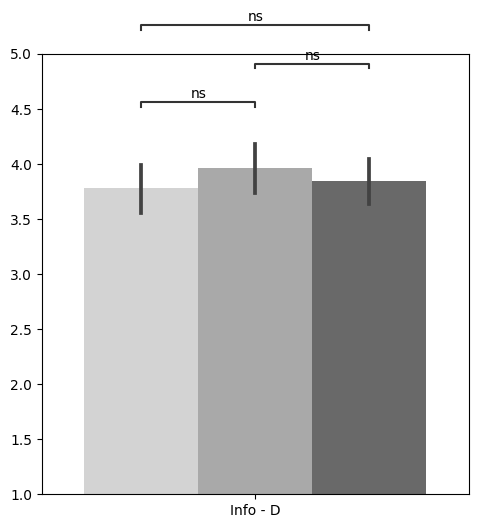

----
Running stats between the samples: ['AI', 'Doctor + AI', 'Doctor']
> Sample size sufficient
   > Sample sizes are unequal and homogeneity *NOT MET*: w_levene=5.286128664189127, p_levene=0.005501559856405616
         > Thus running ANOVA Welch:
            > ANOVA Welch *SIGNIFICANT*: welch=
          Source  ddof1       ddof2         F     p-unc       np2
0  Random Header      2  213.412395  3.377049  0.035983  0.021236

>Thus running Games-Howell test:
        A            B  mean(A)  mean(B)   diff     se      T       df   pval  \
0      AI       Doctor    3.748    3.301  0.447  0.173  2.587  198.567  0.028   
1      AI  Doctor + AI    3.748    3.601  0.147  0.155  0.945  222.328  0.613   
2  Doctor  Doctor + AI    3.301    3.601 -0.300  0.170 -1.759  208.049  0.186   

   hedges  
0   0.359  
1   0.125  
2  -0.233  
mean_std: {'AI': {'mean': 3.7475728155339807, 'std': 1.1317905872428022}, 'Doctor + AI': {'mean': 3.6007999999999996, 'std': 1.2092717083088187}, 'Doctor': {'mean':

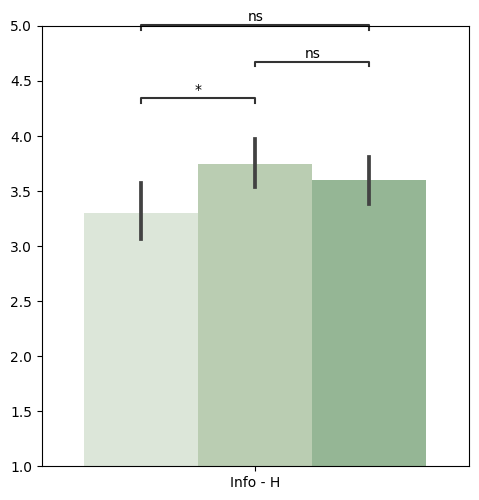

----
Running stats between the samples: ['Doctor', 'Doctor + AI', 'AI']
> Sample size sufficient
   > Sample sizes equal
      > Thus running BASIC ANOVA:
         > Basic ANOVA *NOT SIGNIFICANT*: s_bANOVA=2.681201359872802, p_bANOVA=0.06995043072166633
mean_std: {'Doctor': {'mean': 3.694736842105263, 'std': 1.3019279172890057}, 'Doctor + AI': {'mean': 4.0429906542056075, 'std': 1.117959069485063}, 'AI': {'mean': 3.941880341880342, 'std': 1.0324259442623909}}
----
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Info - L_Doctor vs. Info - L_AI: Custom statistical test, P_val:2.370e-01
Info - L_AI vs. Info - L_Doctor + AI: Custom statistical test, P_val:7.900e-01
Info - L_Doctor vs. Info - L_Doctor + AI: Custom statistical test, P_val:6.600e-02


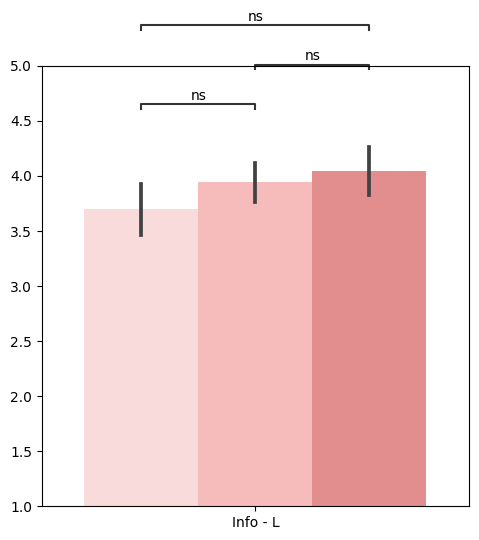

In [15]:
for ques in Question_Names_Eval:
    source_order = [' - D', ' - H', ' - L']
    ques_3_list = list(S3_data["Question Type"])
    source_3_list = list(S3_data["Response Source"])

    for j in range(len(source_order)):
        source = source_order[j]
        palette = palettes_3[j]

        temp_ds = pd.DataFrame()
        temp_ds.insert(0, "Question Type", 0)
        temp_ds.insert(1, "Response Scores", 0)
        temp_ds.insert(2, "Response Source", 0)
        temp_ds.insert(3, "Random Header", 0)

        for i in range(len(ques_3_list)):
            if ques_3_list[i] == ques:
                if source in source_3_list[i]:
                    temp_ds.loc[len(temp_ds)] = S3_data.loc[i, :].values.flatten().tolist()[1:5]
    
        if ques != "Valid":
            plot_params = {
                'x': 'Response Source',
                'y' : "Response Scores",
                'hue' : "Random Header",
                'data' : temp_ds,
                'palette': palette,
                'order' : [ques + source],
                'hue_order' : Random_Headers,
            }
            stats(**plot_params, graph_viz=True, ylim=[1,5], figsize=[5,5], stats_viz=True)

        else:
            plot_params = {
                'x': 'Response Source',
                'y' : "Response Scores",
                'hue' : "Random Header",
                'data' : temp_ds,
                'palette': palette,
                'order' : [ques + source],
                'hue_order' : Random_Headers,
            }
            stats(**plot_params, graph_viz=True, ylim=[0,1], figsize=[5,5], stats_viz=True)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=28896330-bd0f-4f0f-a160-af87c463253f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>